In [1]:
# Import modules
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.pipeline import make_pipeline

today = dt.date.today()
this_month = pd.to_datetime(str(today.year)+'-'+str(today.month)+'-01')
%qtconsole

In [2]:
# Define local directories
master_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\'
data_raw_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\raw\\'
data_interim_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\interim\\'
data_processed_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\processed\\'
data_external_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\external\\'

In [3]:
df = pd.read_csv(data_processed_dir+'processed_data.csv')
df.date = pd.to_datetime(df.date)
df = df.sort_values(by='date', ascending=True).reset_index(drop=True)
df.head(2)

,date,Total US RigCount,wti_spot,wti_spot_lag_14,brent_spot,usa_net_import,usa_stocks_all,usa_l48_prod,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons,non-oecd_cons,world_cons
0,2011-02-04,818.0,89.520,82.030,100.358,8.876,1049.948,4.991,34.562296,33.144409,3.700132,54.123720,47.658621,42.542887,90.201507
1,2011-02-11,805.0,85.514,84.928,99.904,8.233,1050.807,4.995,34.228542,32.844592,3.700252,54.236533,47.483407,42.376184,89.859591


In [4]:
# Remove wti_spot, brent_spot for redundant values with wti_spot_lag_14
df = df.drop(['brent_spot'],axis=1)

# Noticed significant variation in early models that were not present in the majority of the data. 
# SelectKBest ended up adding much more significance to the world_cons data and caused modeling
# issues with MinMaxScaler... Same issues existed with StandardScaler
df = df.drop(['world_cons','oecd_cons','non-oecd_cons','usa_net_import'],axis=1)
df.head(2)

,date,Total US RigCount,wti_spot,wti_spot_lag_14,usa_stocks_all,usa_l48_prod,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod
0,2011-02-04,818.0,89.520,82.030,1049.948,4.991,34.562296,33.144409,3.700132,54.123720
1,2011-02-11,805.0,85.514,84.928,1050.807,4.995,34.228542,32.844592,3.700252,54.236533


## Train Test Split
Define features X, and target variable y

In [5]:
X = df.iloc[:,2:]
y = df.iloc[:,1]

date = df.date

#scaler = MinMaxScaler()
#scaler.fit(df.iloc[:,1:])
#X = scaler.transform(df.iloc[:,1:])
#X = pd.DataFrame(X,columns=df.iloc[:,1:].columns)
#X[['Total US RigCount','wti_spot_lag_14']].plot(figsize=(12,10))

In [6]:
# Define functions
def plot_model(date,X,y,ts_cv,pipe):
    fig, ax = plt.subplots(figsize=(25,10))
    ax.plot(date,y)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth = range(0,13,6)))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=75)

    mse = []
    r2 = []
    mae = []

    for ii, (tr, tt) in enumerate(ts_cv.split(X,y)):
        X_tr = X.iloc[tr,:]
        y_tr = y.iloc[tr]
        X_tt = X.iloc[tt,:]
        y_tt = y.iloc[tt]
        pipe.fit(X_tr,y_tr)

        y_pred = pipe.predict(X_tt)

        mse.append(mean_squared_error(y_pred,y_tt,squared=False))
        r2.append(r2_score(y_pred,y_tt))
        mae.append(mean_absolute_error(y_pred,y_tt))
        
        ax.plot(date[tt],y_pred, label='test iter no '+str(ii+1))

    plt.legend()
    plt.show()

    return 'rmse = '+str(np.mean(mse))+'. r2 = '+str(np.mean(r2))+'. mae = '+str(np.mean(mae))

### Linear Regression 
Baseline model will be a linear regression with all features.

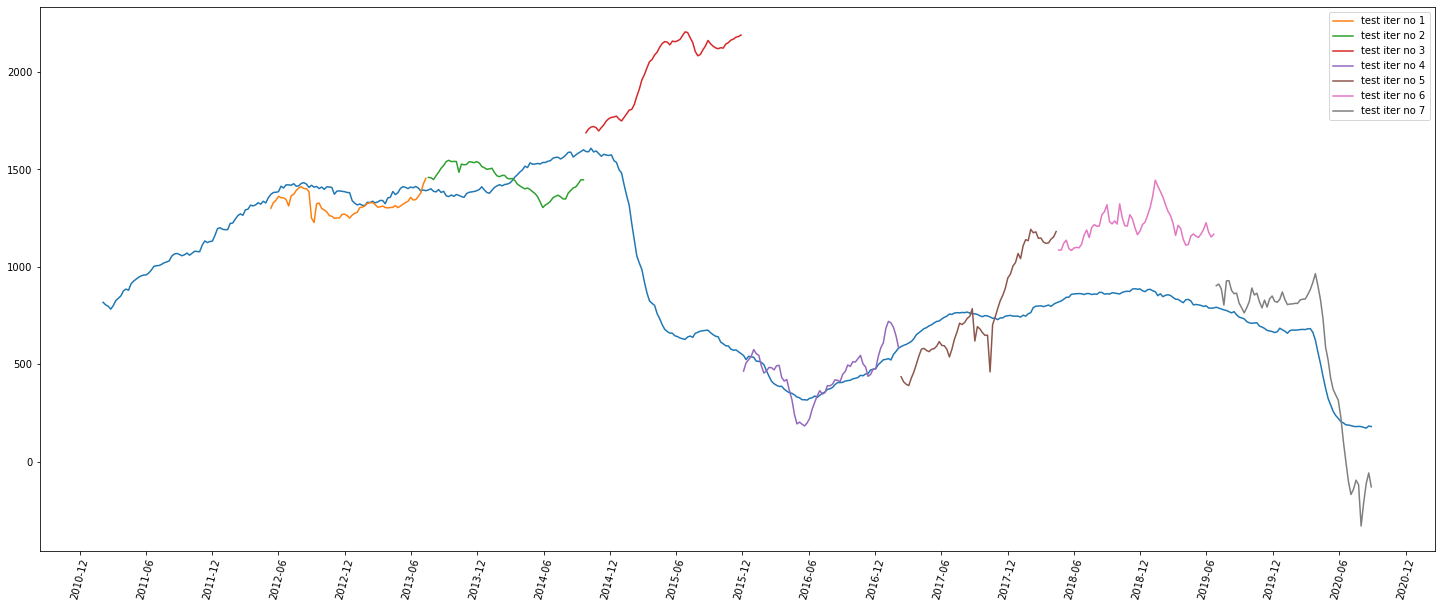

'rmse = 326.52519082695557. r2 = -9.108286436693596. mae = 289.6854731820812'

In [7]:
# Baseline linear regression with no additional features
n_splits = 7

model = LinearRegression()
cv = TimeSeriesSplit(n_splits=n_splits)
pipe = make_pipeline(model)

plot_model(date,X,y,cv,pipe)

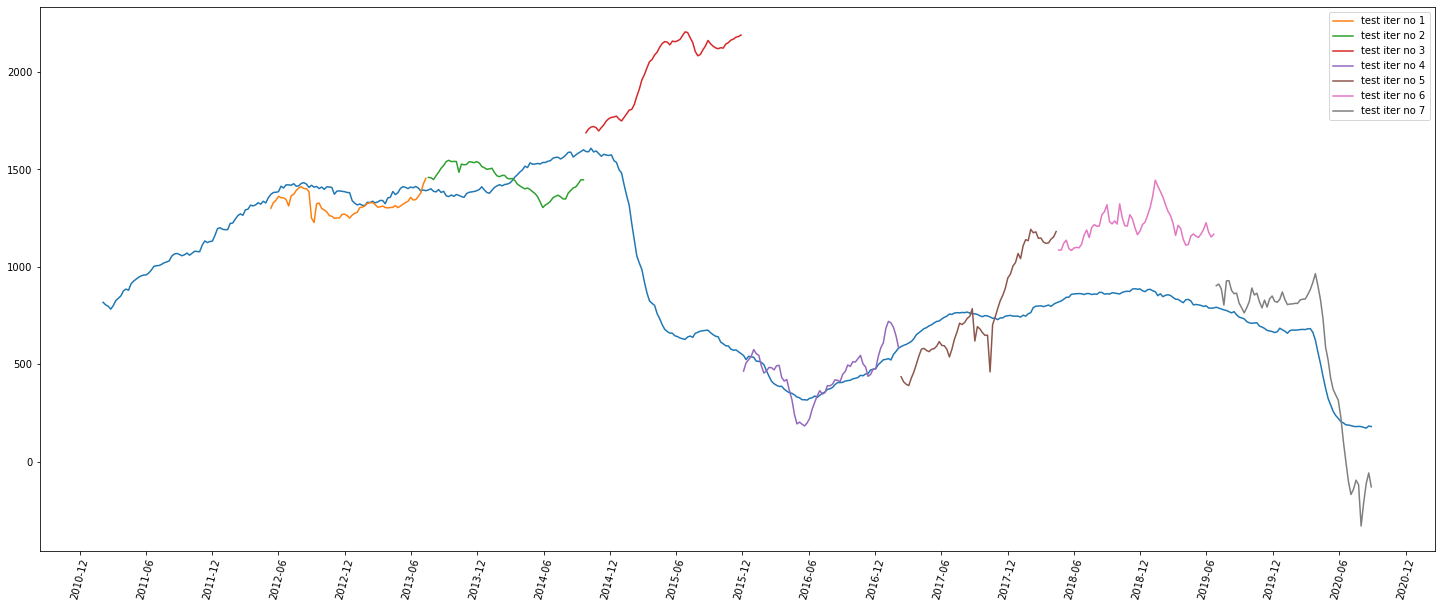

'rmse = 326.5251908269553. r2 = -9.108286436693641. mae = 289.6854731820817'

In [8]:
# Add scaler to features
scaler = StandardScaler()
pipe = make_pipeline(scaler,model)

plot_model(date,X,y,cv,pipe)

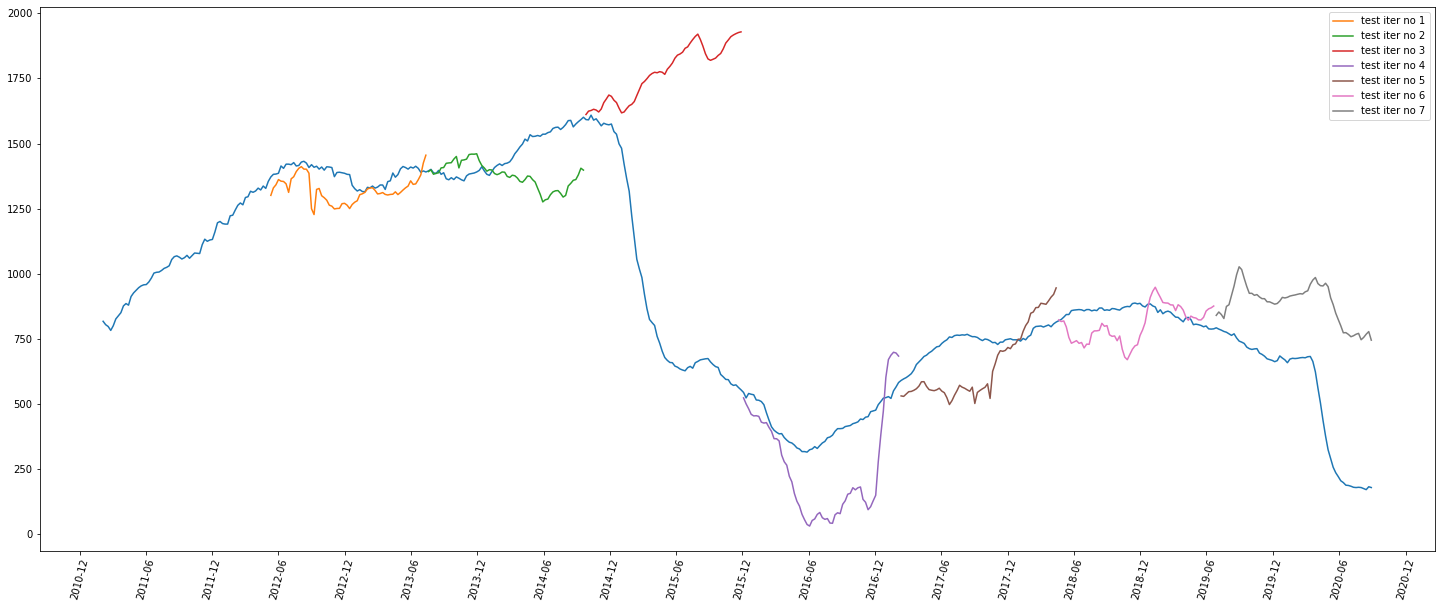

'rmse = 288.8289805519599. r2 = -17.379419488023945. mae = 246.75440514614561'

In [9]:
# Let's try with rolling window for the time series to account for the data being non-stationary
cv = TimeSeriesSplit(n_splits=n_splits,max_train_size=100)

plot_model(date,X,y,cv,pipe)

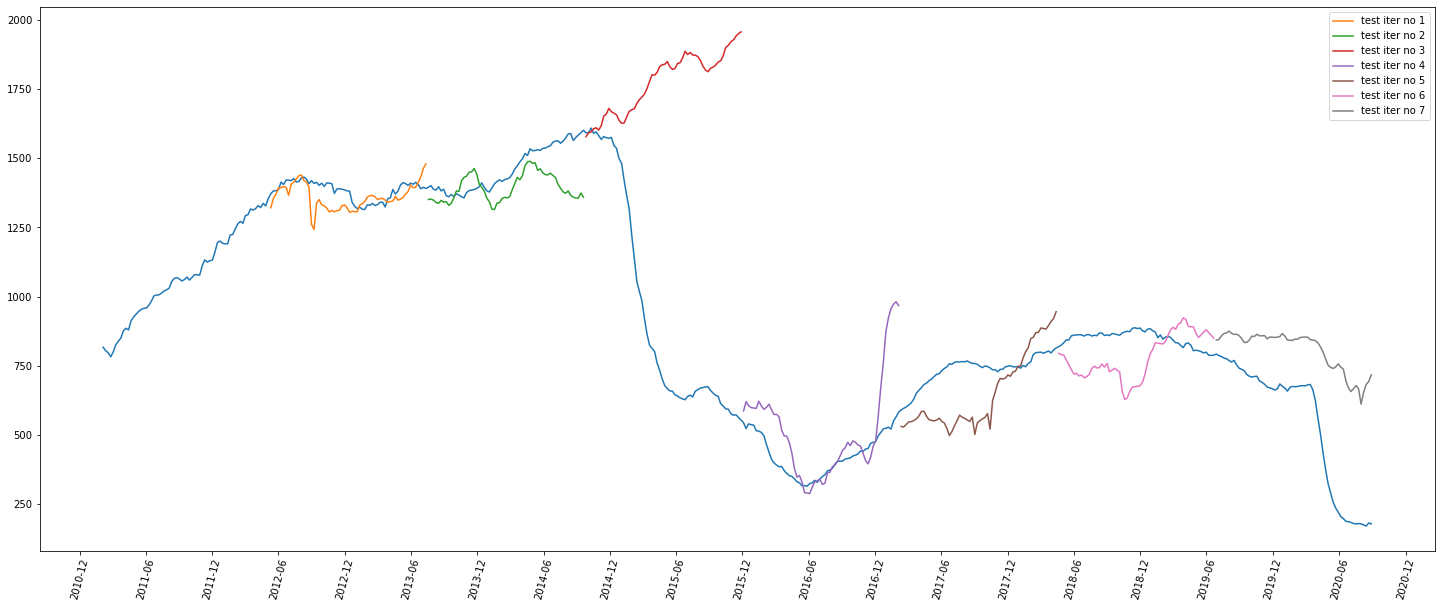

'rmse = 262.3926072492117. r2 = -14.22737196034845. mae = 218.38183332599442'

In [10]:
# Parameter tuning for linear regression
feat_sel = SelectKBest(f_regression)
pipe = make_pipeline(scaler,feat_sel,model)
param_grid = {'selectkbest__k':np.arange(1,len(X.columns)+1)}

gs_cv = GridSearchCV(pipe,param_grid=param_grid,cv=cv,n_jobs=-1)

plot_model(date,X,y,cv,gs_cv)

In [11]:
selected = gs_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = gs_cv.best_estimator_.named_steps.linearregression.coef_
features = X.columns[selected]
features = pd.Series(coefs, index=features).sort_values(ascending=False)

print(gs_cv.best_params_)
print(features)

{'selectkbest__k': 3}
wti_spot_lag_14      30.555177
non-opec_tot_prod    19.966242
opec_crud_capac      -0.155851
dtype: float64


### Ridge Regression 
Baseline model will be a ridge regression with default alpha.

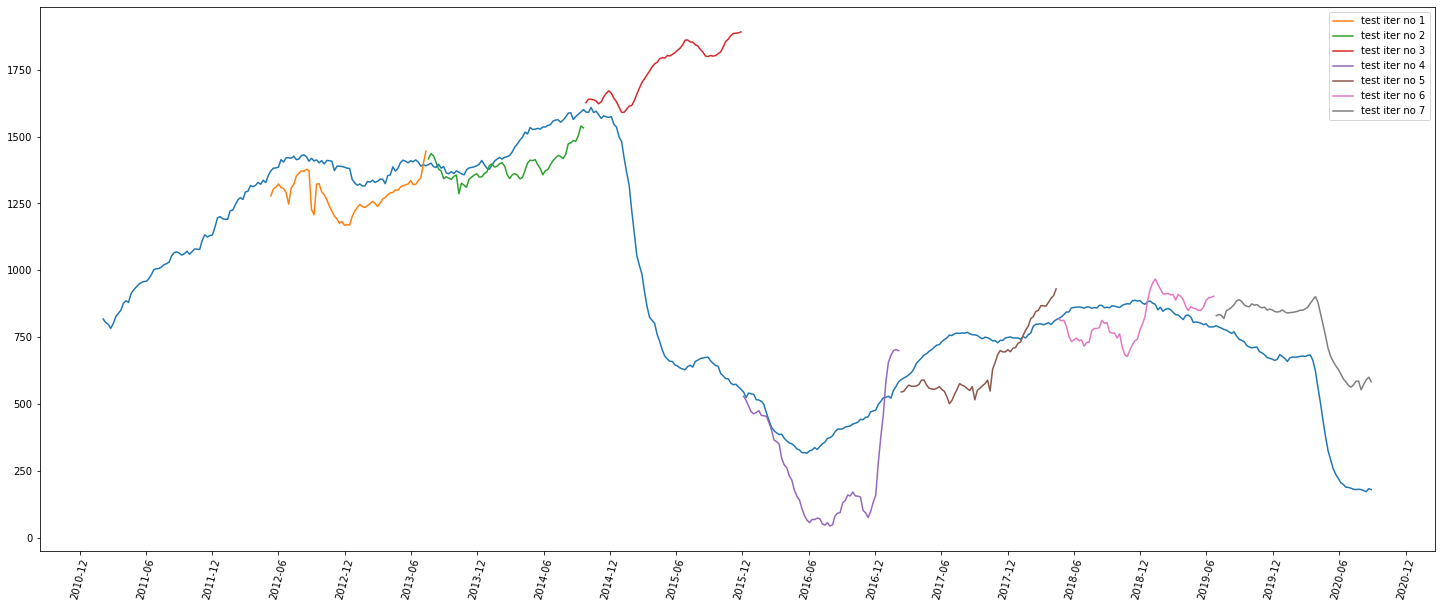

'rmse = 265.4195563681727. r2 = -14.852509979570858. mae = 228.59156176135457'

In [12]:
model = Ridge()
pipe = make_pipeline(scaler,model)

plot_model(date,X,y,cv,pipe)

KeyboardInterrupt: 

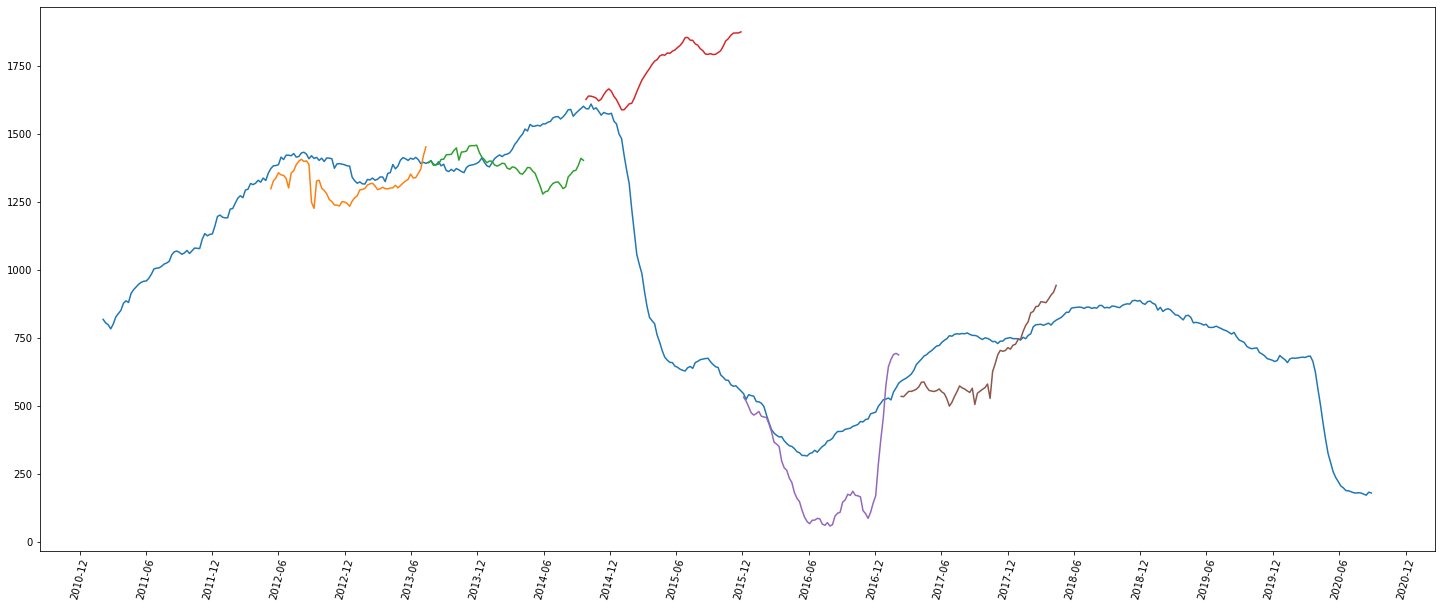

In [13]:
param_grid = {'ridge__alpha':np.arange(0.005,2,step=0.005)}
gs_cv = GridSearchCV(pipe,param_grid=param_grid,cv=cv,n_jobs=-1)

plot_model(date,X,y,cv,gs_cv)

In [ ]:
print(gs_cv.best_estimator_.named_steps.ridge)

In [ ]:
pipe = make_pipeline(scaler,feat_sel,model)

param_grid = {'ridge__alpha':np.arange(0.01,2,step=0.01),'selectkbest__k':np.arange(1,len(X.columns)+1)}
gs_cv = GridSearchCV(pipe,param_grid=param_grid,cv=cv,n_jobs=-1)

plot_model(date,X,y,cv,gs_cv)

In [ ]:
print(gs_cv.best_estimator_.named_steps.ridge)
print(gs_cv.best_estimator_.named_steps.selectkbest)

### Lasso Regression 
Baseline model will be a lasso regression with no alpha optimisation.

In [ ]:
model = Lasso()
pipe = make_pipeline(scaler,feat_sel,model)
param_grid = {'selectkbest__k':np.arange(1,len(X.columns)+1)}

plot_model(date,X,y,cv,model)

In [ ]:
param_grid = {'lasso__alpha':np.arange(0.01,2,step=0.005),'selectkbest__k':np.arange(0,len(X.columns))}
gs_cv = GridSearchCV(pipe,param_grid=param_grid,cv=cv,n_jobs=-1)

plot_model(date,X,y,cv,gs_cv)

In [ ]:
print(gs_cv.best_estimator_.named_steps.lasso)
print(gs_cv.best_estimator_.named_steps.selectkbest)

### Random Forest Regression 
Baseline model will be a default RF regression

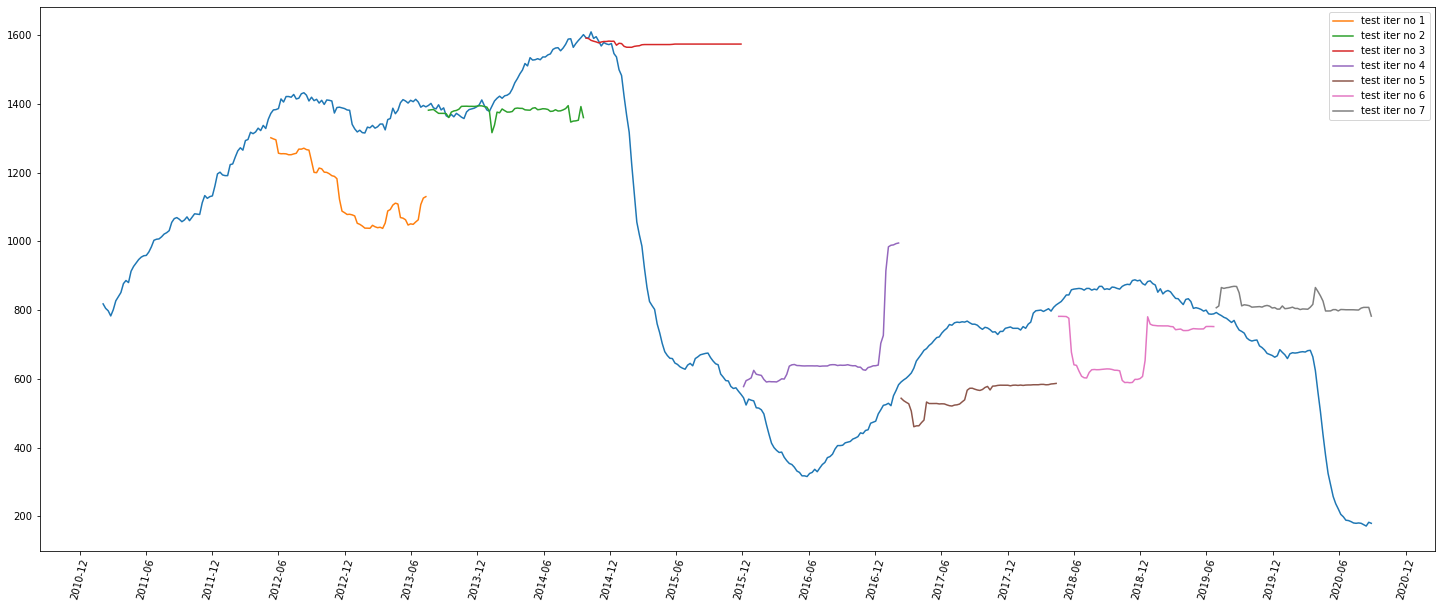

'rmse = 296.25641703369047. r2 = -3084.613794834983. mae = 256.3705069124424'

In [14]:
model = RandomForestRegressor()

pipe = make_pipeline(scaler,model)

plot_model(date,X,y,cv,model)

In [ ]:
param_grid = {
        'randomforestregressor__n_estimators' : np.arange(350,500,step=25)
}

gs_cv = GridSearchCV(pipe,param_grid=param_grid,cv=cv,n_jobs=-1)

plot_model(date,X,y,cv,gs_cv)

In [ ]:
print(gs_cv.best_estimator_.named_steps.randomforestregressor)